In [17]:
# --- Imports standard libraries ---
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import torch.nn.functional as F

# --- Imports project modules ---
import data
import tools
import plot
importlib.reload(data)
importlib.reload(tools)
importlib.reload(plot)

from tools import *      
from data import *
from plot import *

# --- Matplotlib settings ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


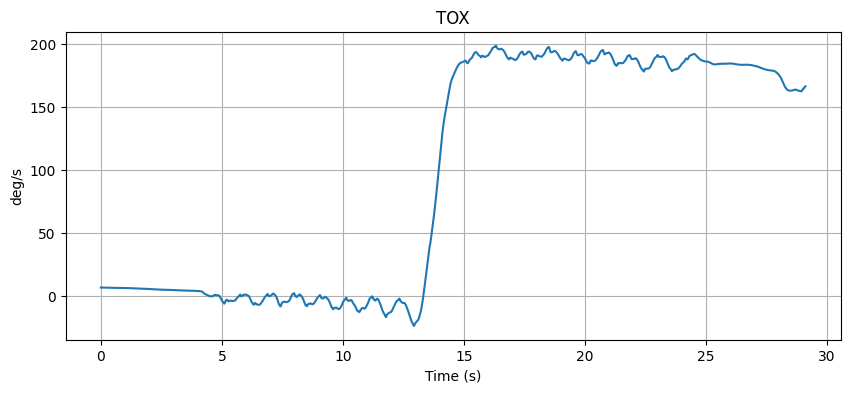

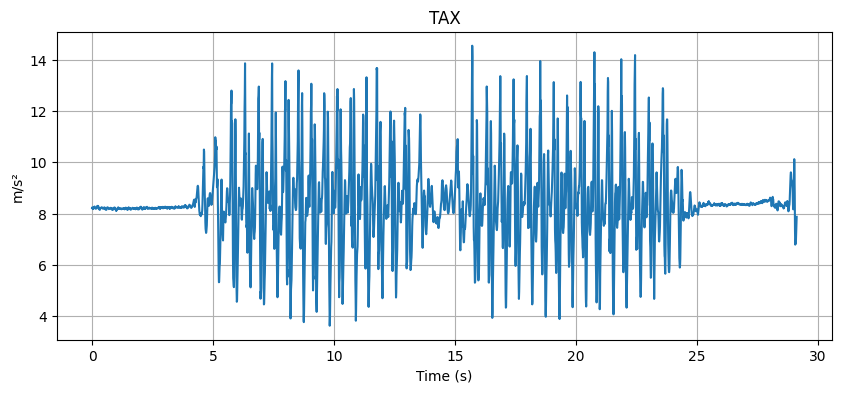

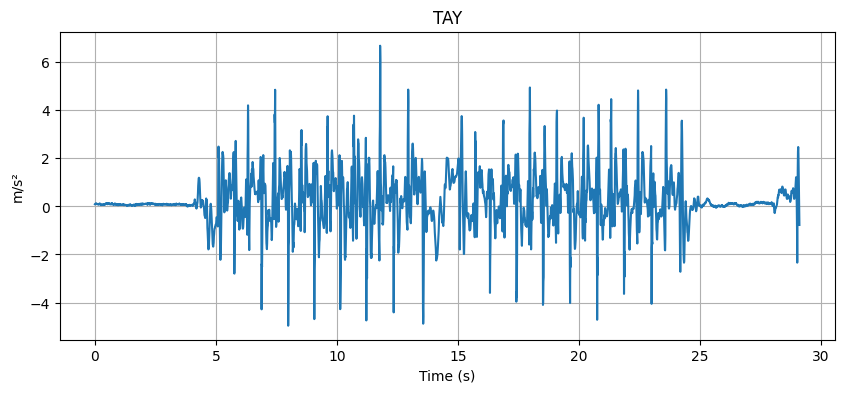

In [31]:
subject = 1
trial = 1
metadata = load_metadata(subject, trial)
signal = load_signal(subject, trial)

#to_plot = ['TOX','TAX','TAY','RAV','RAZ','RRY','LAV','LAZ','LRY']
to_plot = ['TOX','TAX','TAY']
show_plot_simple(signal, to_plot)

In [92]:
import pwlf
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['TAX','TAY'] # ['RAV','RAZ','RRY'] or ['TOX','TAX','TAY']
X = build_X(subjects, signal_names,start=0,end=None, trial=1)
fs = 95.95
best_cutoff = find_optimal_cutoff(X, fs=fs, percentile=0.95)

# Apply these single numbers to your filter function

X_filtered = apply_low_pass(X, best_cutoff, fs=fs,order=3)

""" for subject in range(len(subjects)):
    signal = X_filtered[subject,:,0]
    x = np.arange(len(signal))
    y = signal
    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    res = my_pwlf.fit(3) 
    tendance = my_pwlf.predict(x)
    signal_centre = y - tendance
    signal_centre = signal_centre / np.std(signal_centre)
    X_filtered[subject, :, 0] = torch.from_numpy(signal_centre).float()

X_filtered = torch.tensor(X_filtered, dtype=torch.float32) """


' for subject in range(len(subjects)):\n    signal = X_filtered[subject,:,0]\n    x = np.arange(len(signal))\n    y = signal\n    my_pwlf = pwlf.PiecewiseLinFit(x, y)\n    res = my_pwlf.fit(3) \n    tendance = my_pwlf.predict(x)\n    signal_centre = y - tendance\n    signal_centre = signal_centre / np.std(signal_centre)\n    X_filtered[subject, :, 0] = torch.from_numpy(signal_centre).float()\n\nX_filtered = torch.tensor(X_filtered, dtype=torch.float32) '

In [93]:
## Filtered Signal
X_filtered = torch.tensor(X_filtered, dtype=torch.float32)
Zf,Phif,Af=CDL(X_filtered,nb_atoms=2,lambda_=0.01,n_iters=30,signal_names=signal_names)

In [86]:
K = 2
L = 50
M=30
Phif, Zf, A_0 = set_gait_informed_init(X_filtered, subjects, 1, K, L, M, signal_names, 'patterns_bruts_sujet_1_essai_1.json')

--- Displaying Atoms (Phi) ---


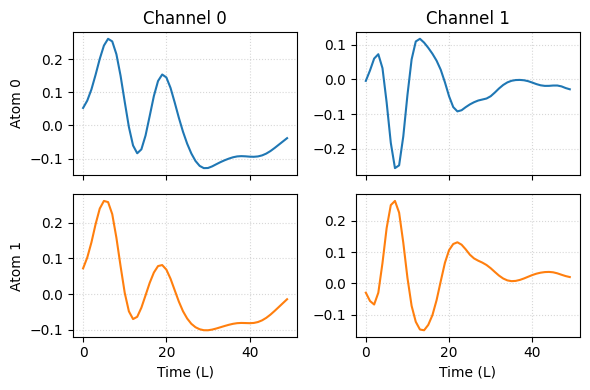


--- Reconstruction and MSE per Subject ---


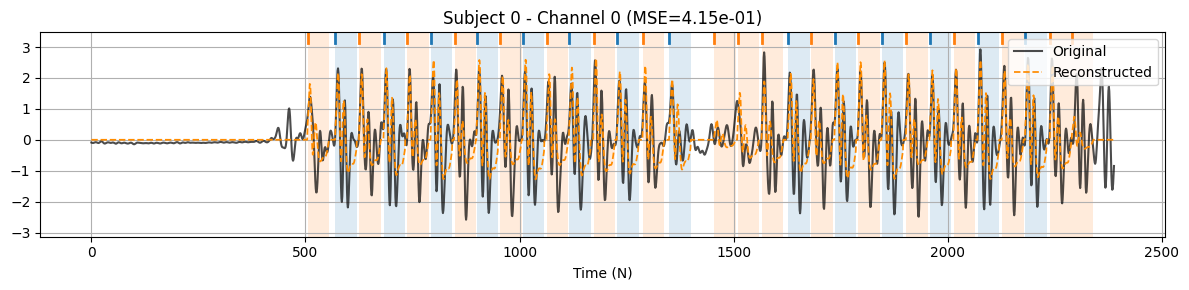

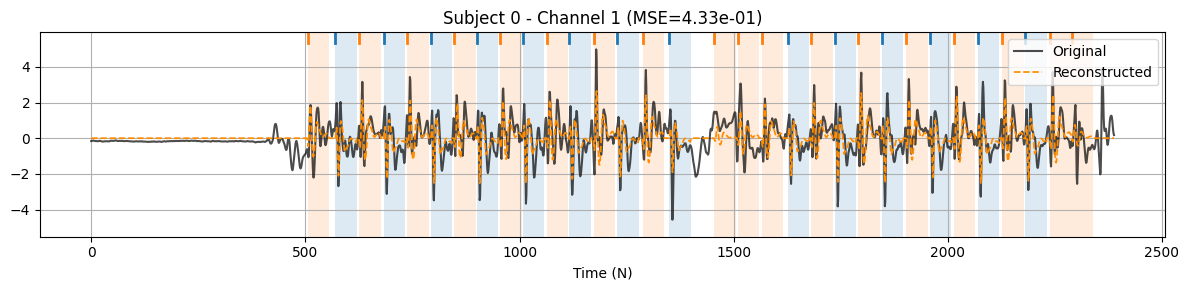


--- Displaying Activations (Z) ---


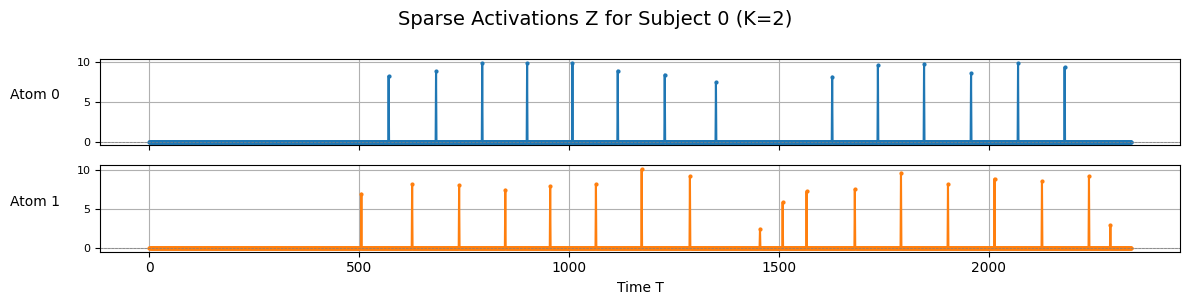


--- Global Statistics ---
MSE Mean: 4.702311e-01 | Std: 9.210449e-02
MSE Min : 3.617793e-01 | Max: 6.844553e-01
Sparsity Rate (>1e-9): 0.6795%
Avg active coefficients per subject: 31.80


In [94]:
full_plot_analysis(X_filtered,Zf,Phif)

In [95]:
# Filtered version
af,zf,phif = Personalization(X_filtered,Af,Zf,Phif,lambda_=0.01,n_perso=30)


  FULL TIME-WARPING ANALYSIS - Subject 0/10

 Global MSE (General): 4.3269e-01
 Global MSE (Warped) : 3.4336e-01
 Improvement Gain    : 20.65%

--- Warped Reconstruction Visualization (Subject 0) ---


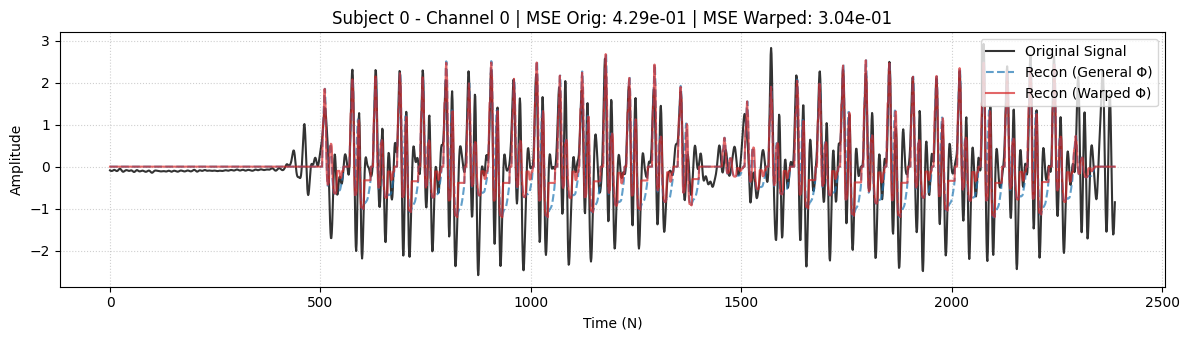

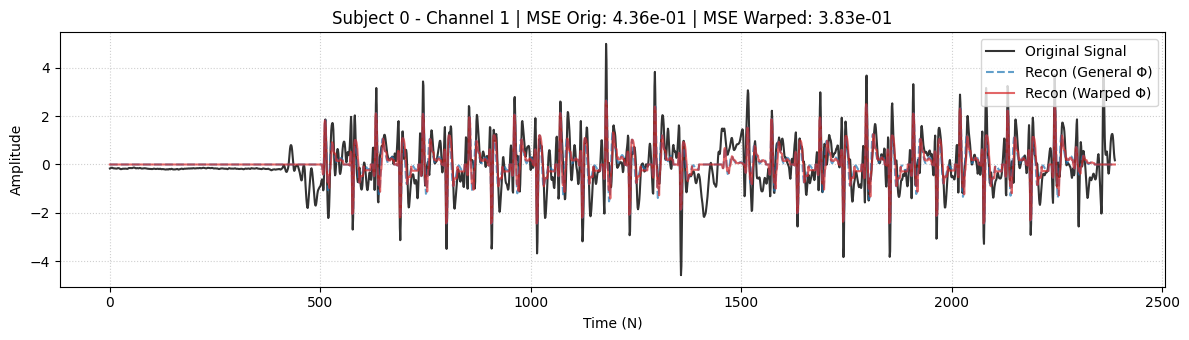


--- MSE Comparison (Subject 0) ---


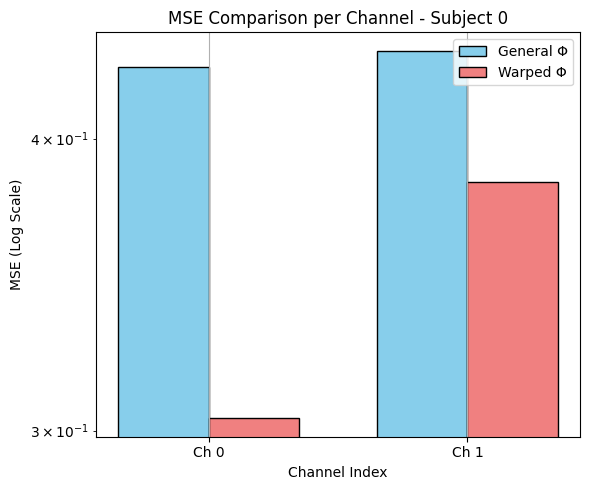


--- General vs. Personalized Atoms (Subject 0) ---


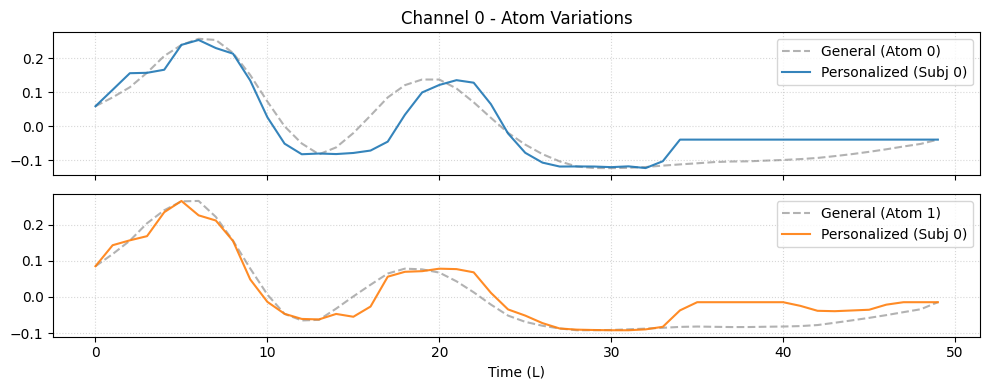

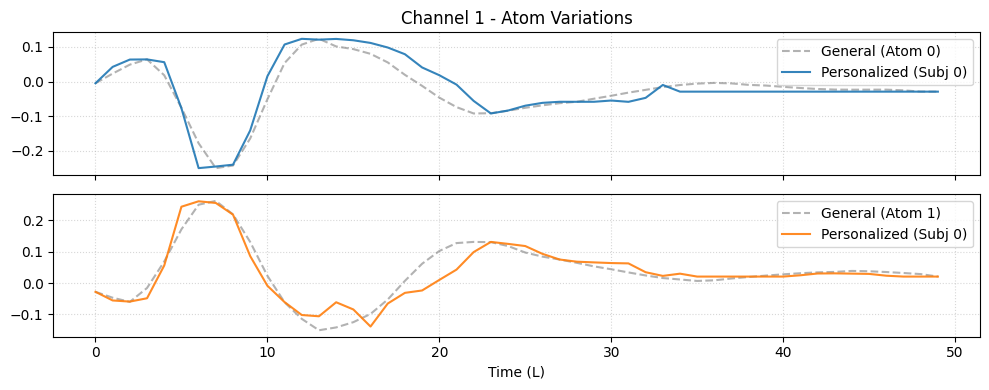

In [96]:
full_warping_analysis(X_filtered,zf,phif,af)

In [8]:
def plot_gait_cycles_by_index(subject, trial):
    """
    Plots all signal channels using sample index as the X-axis.
    Blue lines = Left foot start index, Red lines = Right foot start index.
    """
    # Load data
    signal = load_signal(subject, trial)
    left_indices, right_indices = get_gait_cycle_indices(subject, trial)
    
    # Identify channels to plot (exclude 'Time' if you want to plot strictly by index)
    channels = [col for col in signal.columns if col != 'Time']
    
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 18), sharex=True)
    
    # Use the range of the dataframe length for the X-axis
    indices = signal.index 
    
    for i, col in enumerate(channels):
        ax = axes[i]
        ax.plot(indices, signal[col], color='black', lw=1)
        ax.set_ylabel(col)
        
        # Add Left Foot Starts (Blue)
        for l_idx in left_indices:
            ax.axvline(x=l_idx, color='blue', linestyle='--', alpha=0.7)
            
        # Add Right Foot Starts (Red)
        for r_idx in right_indices:
            ax.axvline(x=r_idx, color='red', linestyle='-', alpha=0.7)
            
        # Add legend only to the first plot
        if i == 0:
            from matplotlib.lines import Line2D
            custom_lines = [Line2D([0], [0], color='blue', lw=2, linestyle='--'),
                            Line2D([0], [0], color='red', lw=2)]
            ax.legend(custom_lines, ['Left Start', 'Right Start'], loc='upper right')

    axes[-1].set_xlabel("Sample Index")
    plt.tight_layout()
    plt.show()

Left starts at indices: [519, 632, 729, 822, 918, 1013, 1109, 1210, 1409, 1529, 1632, 1732, 1832, 1933, 2035, 2141]


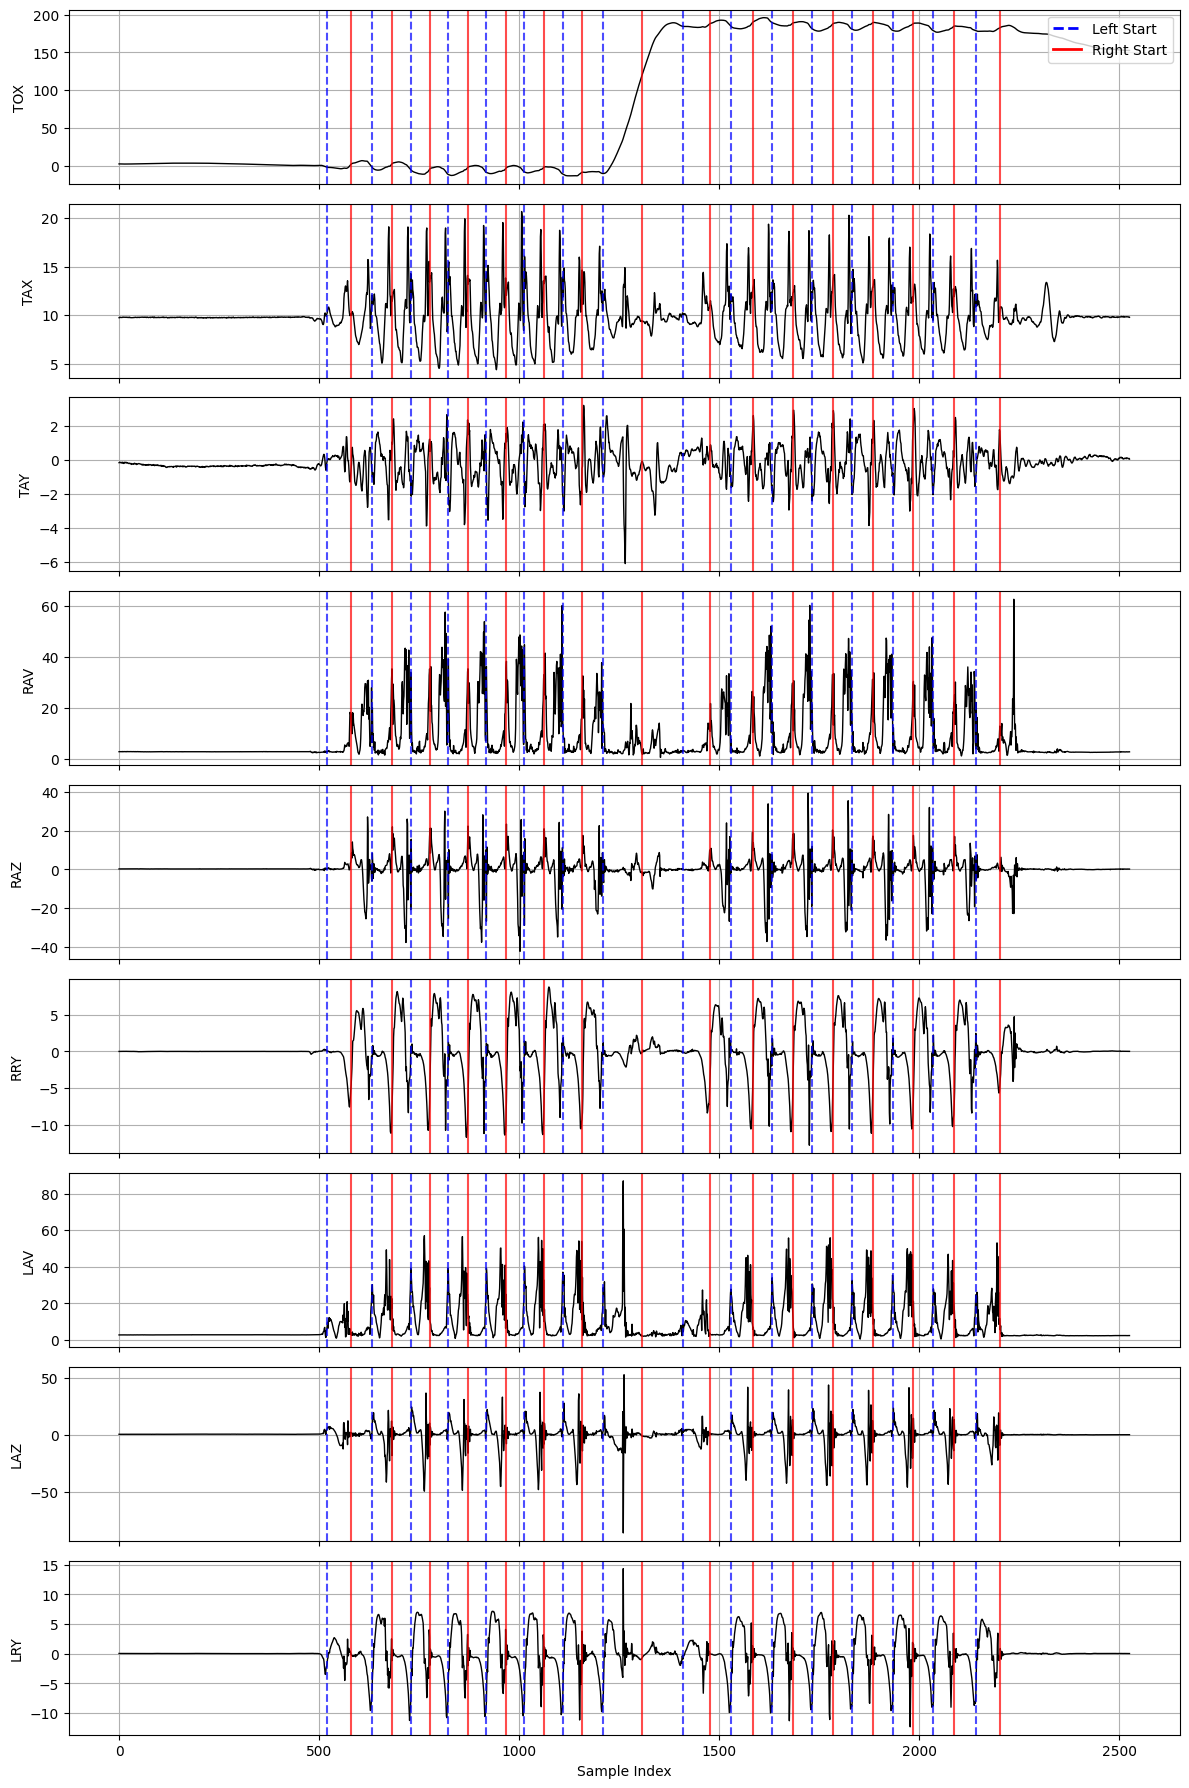

In [9]:
subject_id = 10
trial_id = 2

# Get the lists
l_idx, r_idx = get_gait_cycle_indices(subject_id, trial_id)
print(f"Left starts at indices: {l_idx}")

# Show the plot
plot_gait_cycles_by_index(subject_id, trial_id)